In [ ]:
%pip install duckdb

In [1]:
import duckdb

In [2]:
cn = duckdb.connect()
cn.sql("create or replace view v_detail_workouts as select * from read_csv_auto('~/concept2/workouts/*detail*.csv')")
cn.sql("create or replace view v_summary_workouts as select * from read_csv_auto('~/concept2/workouts/*summary*.csv')")

In [3]:
cn.sql("from v_detail_workouts limit 3").show()

sql = """
    select machine_type, count(*) as stroke_cnt
    , round(avg("stroke rate"),2) as avg_stroke_rate
    from v_detail_workouts
    group by 1
"""
cn.sql(sql).show()


┌────────┬────────────────┬───────────────────┬────────────────┬───────┬────────┬─────────────┬────────────┬────────┬────────────┬──────────────┐
│ Number │ Time (seconds) │ Distance (meters) │ Pace (seconds) │ Watts │ Cal/Hr │ Stroke Rate │ Heart Rate │ season │    date    │ machine_type │
│ int64  │     double     │      double       │     double     │ int64 │ int64  │    int64    │   int64    │ int64  │    date    │   varchar    │
├────────┼────────────────┼───────────────────┼────────────────┼───────┼────────┼─────────────┼────────────┼────────┼────────────┼──────────────┤
│      1 │            0.7 │               2.1 │            0.0 │  NULL │   NULL │        NULL │       NULL │   2024 │ 2024-04-03 │ rowerg       │
│      2 │            2.7 │               8.8 │          169.5 │    72 │    547 │        NULL │       NULL │   2024 │ 2024-04-03 │ rowerg       │
│      3 │            5.2 │              17.1 │          150.1 │   103 │    656 │          27 │       NULL │   2024 │ 2024-0

In [ ]:
## need to update to use the "grouping" function to tag totals and sub totals


sql = """
    select 
        coalesce(
            cast(season as varchar(30)),
            case 
                when season is null then 'All Seasons'
                else cast(season as varchar(30))
            end
        ) as season,
        coalesce(
            type,
            case 
                when type is null then 'All Machines'
                else type
            end
        ) as type,
        sum("Work Distance") as total_meters,
        round(sum("Work Distance")*0.000621371,0) as total_miles,
        round(avg("Drag Factor"),2) as avg_drag_factor,
        round(avg("Stroke Rate/Cadence"),2) as avg_stroke_rate,
        sum("Stroke Count") as total_strokes,
        round(sum("Work Time (Seconds)"),0) as total_seconds,
        sum("Total Cal") as total_calories,
        round(sum("Total Cal")/3500,0) as fat_lbs_burned
    from v_summary_workouts
    group by grouping sets
    (
         (season, type)
        ,(type)
        ,(season)
        ,()
    )
    order by season, type
"""
cn.sql(sql).show()


┌─────────────┬──────────────┬──────────────┬───────────────┬─────────────────┬─────────────────┬───────────────┬───────────────┬────────────────┬────────────────┐
│   season    │     type     │ total_meters │  total_miles  │ avg_drag_factor │ avg_stroke_rate │ total_strokes │ total_seconds │ total_calories │ fat_lbs_burned │
│   varchar   │   varchar    │    int128    │ decimal(38,0) │     double      │     double      │    int128     │    double     │     int128     │     double     │
├─────────────┼──────────────┼──────────────┼───────────────┼─────────────────┼─────────────────┼───────────────┼───────────────┼────────────────┼────────────────┤
│ 2024        │ All Machines │        85997 │            53 │          124.13 │            25.0 │          1322 │       20906.0 │           5612 │            2.0 │
│ 2024        │ RowErg       │        85997 │            53 │          124.13 │            25.0 │          1322 │       20906.0 │           5612 │            2.0 │
│ 2025        │ 

In [ ]:
sql = """

    select 
        "date" as workout_date
        , "Time (seconds)" as time_seconds
        , "Distance (meters)" as distance_meters
        ,format('{:02d}:{:02d}', 
            cast(floor("Time (seconds)" / 60) as int), 
            cast(round("Time (seconds)") % 60 as int)
        ) as time_mmss
    from v_detail_workouts
    where 1=1
        and machine_type = 'rowerg'
        and "Distance (meters)" >= 5000
    qualify 1 = rank() over(partition by "date" order by "Number")
    order by "Time (seconds)" desc
    limit 10

"""
cn.sql(sql).show()

┌──────────────┬──────────────┬─────────────────┬───────────┐
│ workout_date │ time_seconds │ distance_meters │ time_mmss │
│     date     │    double    │     double      │  varchar  │
├──────────────┼──────────────┼─────────────────┼───────────┤
│ 2024-08-08   │       1235.5 │          5000.0 │ 20:36     │
│ 2024-09-18   │       1229.2 │          5005.1 │ 20:29     │
│ 2024-08-01   │       1221.1 │          5002.8 │ 20:21     │
│ 2025-01-09   │       1220.7 │          5007.1 │ 20:21     │
│ 2024-08-15   │       1219.9 │          5007.9 │ 20:20     │
│ 2024-04-03   │       1217.4 │          5006.5 │ 20:17     │
│ 2024-09-23   │       1215.4 │          5002.7 │ 20:15     │
│ 2024-09-09   │       1208.2 │          5006.0 │ 20:08     │
│ 2024-08-22   │       1208.1 │          5003.4 │ 20:08     │
│ 2024-08-13   │       1207.0 │          5012.1 │ 20:07     │
├──────────────┴──────────────┴─────────────────┴───────────┤
│ 10 rows                                         4 columns │
└───────

In [ ]:
sql = """
    select
        year("date") as year,
        month("date") as month,
        sum("Work Distance") as total_meters
    from v_summary_workouts
    group by all
    order by year, month

"""

cn.sql(sql).show()

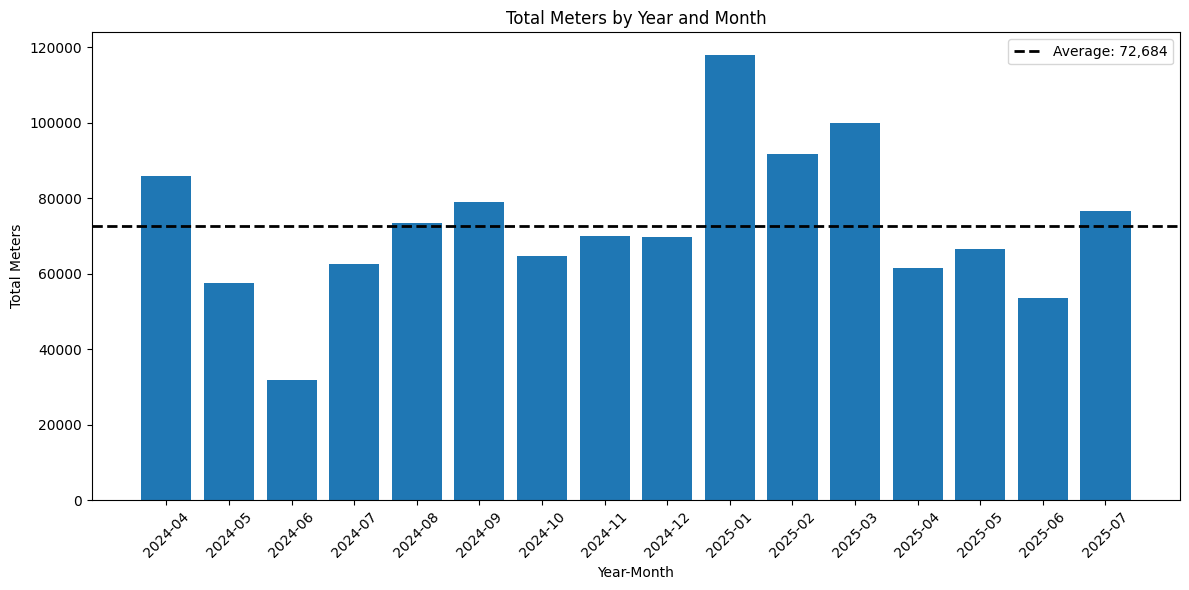

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
df = cn.sql(sql).df()
df['year_month'] = df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2)

plt.figure(figsize=(12,6))
plt.bar(df['year_month'], df['total_meters'])
avg_total_meters = df['total_meters'].mean()

# Add a dashed black line for the average
plt.axhline(avg_total_meters, color='black', linestyle='dashed', linewidth=2, label=f'Average: {avg_total_meters:,.0f}')

plt.xlabel('Year-Month')
plt.ylabel('Total Meters')
plt.title('Total Meters by Year and Month')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()